<a href="https://colab.research.google.com/github/treiro/Unet-ISBI-Keras/blob/main/ISBI_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%ls

data/    gdrive/        __pycache__/  USBI_UNET.ipynb
data.py  model-isbi.h5  sample_data/


In [ ]:
%cp -r gdrive/MyDrive/COLAB/Unet/UNET-ISBI-KERAS/* .

## Data augmentation

In [ ]:
from data import *
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    validation_split=0.2,
                    fill_mode='nearest')
trainGenerator = trainGenerator(20,'data/membrane/train','image','label',data_gen_args,save_to_dir = "data/membrane/train/aug")
print(trainGenerator)
validGenerator = validGenerator(20,'data/membrane/train','image','label',data_gen_args,save_to_dir = "data/membrane/train/aug")


<generator object trainGenerator at 0x7fb5a98a9750>


## visualize your data augmentation result

In [ ]:
#you will see 60 transformed images and their masks in data/membrane/train/aug
num_batch = 3
for i,batch in enumerate(trainGenerator):
    if(i >= num_batch):
        break

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


###  Display 5 image on aug

['data/membrane/train/aug/image_0_9077178.png', 'data/membrane/train/aug/image_0_9986536.png', 'data/membrane/train/aug/image_10_6660088.png', 'data/membrane/train/aug/image_10_7714598.png', 'data/membrane/train/aug/image_11_2837909.png']
['data/membrane/train/aug/mask_0_9077178.png', 'data/membrane/train/aug/mask_0_9986536.png', 'data/membrane/train/aug/mask_10_6660088.png', 'data/membrane/train/aug/mask_10_7714598.png', 'data/membrane/train/aug/mask_11_2837909.png']


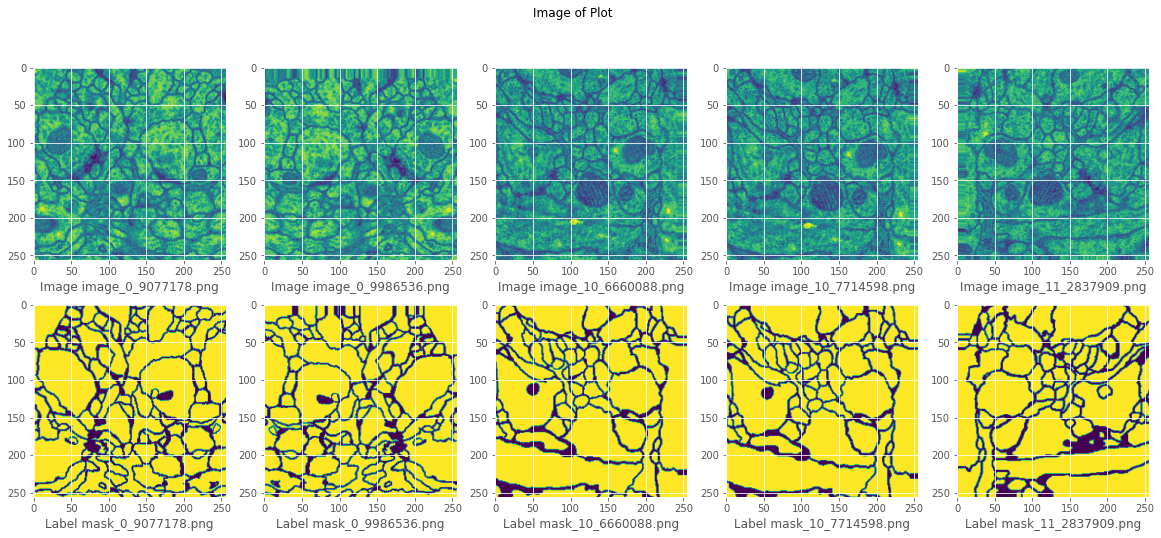

In [ ]:
import glob2

img_5_paths = sorted(glob2.glob('data/membrane/train/aug/image_*.png'))[:5]
label_5_paths = sorted(glob2.glob('data/membrane/train/aug/mask_*.png'))[:5]
print(img_5_paths)
print(label_5_paths)
# Visualize top 5 aug first image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

# Init subplot 2 rows 5 columns.
fg, ax = plt.subplots(2, 5, figsize=(20, 8))
fg.suptitle('Image of Plot')

for i, path in enumerate(img_5_paths):
  image = plt.imread(path)
  ax[0, i].imshow(image)
  ax[0, i].set_xlabel('Image ' + path.split('/')[-1])

for i, path in enumerate(label_5_paths):
  label = plt.imread(path)
  ax[1, i].imshow(label)
  ax[1, i].set_xlabel('Label ' + path.split('/')[-1])

## Split train and validation

In [ ]:
from sklearn.model_selection import train_test_split
import glob2
#Read aug folder
image_augs = glob2.glob('data/membrane/train/aug/*.png')
print(image_augs)
label_path_aug = [item for item in image_augs if 'mask_' in item]
image_path_aug = [item for item in image_augs if 'image_' in item]
print(label_path_aug)
print(image_path_aug)
# image_names = [item.split('/')[-1] for item in label_path_aug]
# image_path_aug = ['data/membrane/train/aug/image'+item[4:] for item in image_names]

#Read image + label folder
image_paths = glob2.glob('data/membrane/train/image/*.png')
label_paths = glob2.glob('data/membrane/train/label/*.png')
# label_paths = ['data/membrane/train/label/' + path.split('/')[-1] for path in image_paths]

image_paths += image_path_aug
label_paths += label_path_aug

train_img_paths, val_img_paths, train_label_paths, val_label_paths = train_test_split(image_paths, label_paths, test_size = 0.2)
print(train_img_paths)
print(len(train_img_paths))
print(len(val_img_paths))

['data/membrane/train/aug/mask_0_9986536.png', 'data/membrane/train/aug/image_19_3484329.png', 'data/membrane/train/aug/mask_4_8710326.png', 'data/membrane/train/aug/image_3_559344.png', 'data/membrane/train/aug/mask_7_6224010.png', 'data/membrane/train/aug/mask_25_124914.png', 'data/membrane/train/aug/mask_26_1931026.png', 'data/membrane/train/aug/mask_9_5969630.png', 'data/membrane/train/aug/image_9_8002635.png', 'data/membrane/train/aug/mask_1_3080959.png', 'data/membrane/train/aug/mask_6_53373.png', 'data/membrane/train/aug/mask_20_7169350.png', 'data/membrane/train/aug/mask_29_8786524.png', 'data/membrane/train/aug/image_16_2807358.png', 'data/membrane/train/aug/image_13_2917011.png', 'data/membrane/train/aug/image_29_8786524.png', 'data/membrane/train/aug/image_25_124914.png', 'data/membrane/train/aug/mask_29_7125951.png', 'data/membrane/train/aug/mask_12_6474794.png', 'data/membrane/train/aug/image_10_7714598.png', 'data/membrane/train/aug/mask_1_6725311.png', 'data/membrane/tra

## Load image data

In [ ]:
import cv2
# INPUT_SHAPE = 572
# OUTPUT_SHAPE = 388
INPUT_SHAPE = 256
OUTPUT_SHAPE = 256
def image_read_paths(train_img_paths, train_label_paths):
  X, Y = [], []
  for image_path, label_path in zip(train_img_paths, train_label_paths):
    image = cv2.imread(image_path)
    image_resize = cv2.resize(image, (INPUT_SHAPE, INPUT_SHAPE), cv2.INTER_LINEAR)
    label = cv2.imread(label_path)
    label_gray = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
    label_resize = cv2.resize(label_gray, (OUTPUT_SHAPE, OUTPUT_SHAPE), cv2.INTER_LINEAR)
    label_binary = np.array(label_resize ==255).astype('float32')
    # label_binary = np.array(label_resize).astype('float32')
    # label_resize =  label_resize/255.0
    # label_binary = np.array(label_resize > 0).astype('float32')
    # image_resize  =  image_resize/255.0

    label_binary = label_binary[..., np.newaxis]

    # print(image_resize)
    # print('........................')
    # print(label_binary)
    # print('--------')

    X.append(image_resize)
    Y.append(label_binary)
  X = np.stack(X)
  Y = np.stack(Y)
  return X, Y
def image_read_paths1(train_img_paths, train_label_paths):
  X, Y = [], []
  for image_path, label_path in zip(train_img_paths, train_label_paths):
    #GRAY
    image = cv2.imread(image_path, 0)
    image_resize = cv2.resize(image, (INPUT_SHAPE, INPUT_SHAPE), cv2.INTER_LINEAR)
    label_gray = cv2.imread(label_path, 0)
    label_resize = cv2.resize(label_gray, (OUTPUT_SHAPE, OUTPUT_SHAPE), cv2.INTER_LINEAR)
    label_binary = np.array(label_resize ==255).astype('float32')
    # label_binary = np.array(label_resize).astype('float32')
    # label_resize =  label_resize/255.0
    # label_binary = np.array(label_resize > 0).astype('float32')
    image_resize  =  image_resize/255.0
    image_resize = image_resize[..., np.newaxis]
    label_binary = label_binary[..., np.newaxis]

    print(image_resize)
    print('........................')
    print(label_binary)
    print('--------')

    X.append(image_resize)
    Y.append(label_binary)
  X = np.stack(X)
  Y = np.stack(Y)
  return X, Y
# def load_image_paths(train_img_paths, train_label_paths):
#   X, Y = [], []
#   for image_path, label_path in zip(train_img_paths, train_label_paths):
#     image = plt.imread(image_path)
#     image_resize = resize(image,(INPUT_SHAPE,INPUT_SHAPE,3),mode = 'constant', preserve_range = True)
#     label = plt.imread(label_path)
#     label_resize = resize(label,(INPUT_SHAPE,INPUT_SHAPE, 1),mode = 'constant', preserve_range = True)
#     print(image)
#     print('--------')
#     # print(label_resize)
#     # label_resize = label_resize/255.0
#     # image_resize = image_resize/255.0
#     X.append(image_resize)
#     Y.append(label_resize)
#   X = np.stack(X)
#   Y = np.stack(Y)
#   return X, Y
X_train, Y_train = image_read_paths(train_img_paths, train_label_paths)
print(X_train.shape, Y_train.shape)
# print(Y_train[0])
X_val, Y_val = image_read_paths(val_img_paths, val_label_paths)
print(X_val.shape, Y_val.shape)

(72, 256, 256, 3) (72, 256, 256, 1)
(18, 256, 256, 3) (18, 256, 256, 1)


In [ ]:
print(X_train.shape)
print(Y_train.shape)


(72, 256, 256, 3)
(72, 256, 256, 1)


In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
def unet(pretrained_weights = None,input_size = (572,572,1), lr=1e-4):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2),strides=2)(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2),strides=2)(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2),strides=2)(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2),strides=2)(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

          
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), activation = 'relu', padding="valid",kernel_initializer = 'he_normal')(drop5)
    merge6 = concatenate([drop4[:,4:60,4:60,:],up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), activation = 'relu', padding="valid",kernel_initializer = 'he_normal')(conv6)
    merge7 = concatenate([conv3[:,16:120,16:120,:],up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), activation = 'relu', padding="valid",kernel_initializer = 'he_normal')(conv7)
    merge8 = concatenate([conv2[:,40:240,40:240,:],up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), activation = 'relu', padding="valid",kernel_initializer = 'he_normal')(conv8)
    merge9 = concatenate([conv1[:,88:480,88:480,:],up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(1, 1, padding = 'valid', activation = 'sigmoid', kernel_initializer = 'he_normal')(conv9)
    # conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv9)

    model.compile(optimizer = Adam(lr = lr), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [ ]:
# input_img = Input((im_height, im_width, 1), name='img')
input_img = Input((INPUT_SHAPE, INPUT_SHAPE, 3), name='img')
model = get_unet(input_img, n_filters=64, dropout=0.05, batchnorm=True)
# model = unet()
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 64) 1792        img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 256, 256, 64) 256         conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 256, 256, 64) 0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

In [ ]:
callbacks = [
    EarlyStopping(patience=2, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-isbi.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

## MODEL 1: Train with model 256x256=>**256x256**

In [ ]:
results = model.fit(X_train, Y_train, batch_size=8, epochs=100, callbacks=callbacks,\
                    validation_data=(X_val, Y_val))

Epoch 1/100
9/9 [==============================] - 6s 624ms/step - loss: 0.5904 - accuracy: 0.7172 - val_loss: 0.5907 - val_accuracy: 0.7241

Epoch 00001: val_loss did not improve from 0.43122
Epoch 2/100
9/9 [==============================] - 6s 625ms/step - loss: 0.5793 - accuracy: 0.7205 - val_loss: 0.5879 - val_accuracy: 0.7242

Epoch 00002: val_loss did not improve from 0.43122
Epoch 3/100
9/9 [==============================] - 6s 629ms/step - loss: 0.5599 - accuracy: 0.7279 - val_loss: 0.5868 - val_accuracy: 0.7236

Epoch 00003: val_loss did not improve from 0.43122
Epoch 4/100
9/9 [==============================] - 6s 636ms/step - loss: 0.5473 - accuracy: 0.7345 - val_loss: 0.5848 - val_accuracy: 0.7231

Epoch 00004: val_loss did not improve from 0.43122
Epoch 5/100
9/9 [==============================] - 6s 638ms/step - loss: 0.5432 - accuracy: 0.7368 - val_loss: 0.5829 - val_accuracy: 0.7226

Epoch 00005: val_loss did not improve from 0.43122
Epoch 6/100
9/9 [==================

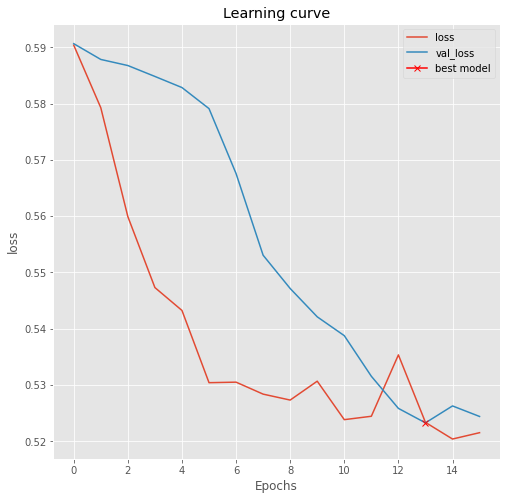

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();

### Accuracy-Loss

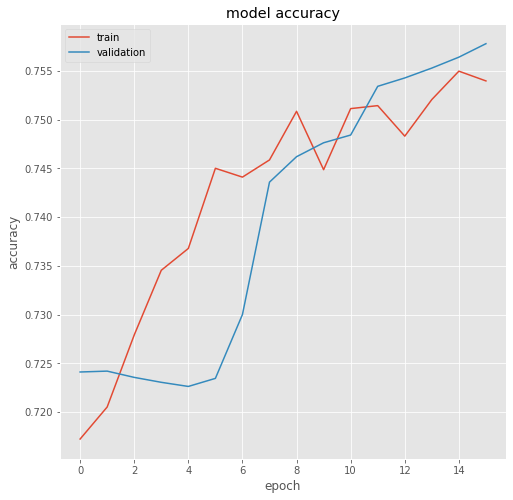

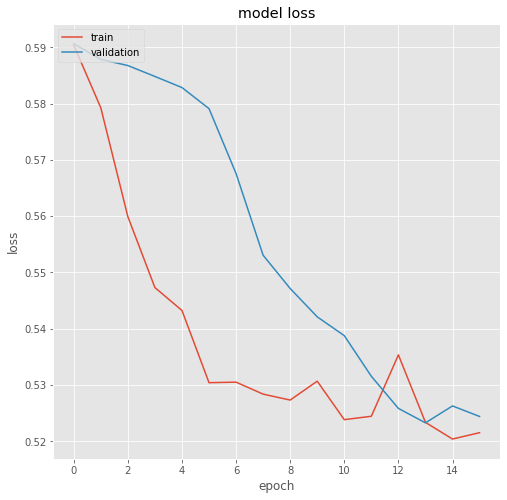

In [ ]:
#  "Accuracy"
plt.figure(figsize=(8, 8))
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('unet_final_4_acc')
plt.show()
# "Loss"
plt.figure(figsize=(8, 8))
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('unet_final_4_loss')
plt.show()


### Inference

In [ ]:
# load the best model
model.load_weights('model-isbi.h5')

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_val, Y_val, verbose=1)

1/1 [==============================] - 0s 448ms/step - loss: 0.5946 - accuracy: 0.7215


[0.5946460962295532, 0.7215457558631897]

### Predic Image on on test

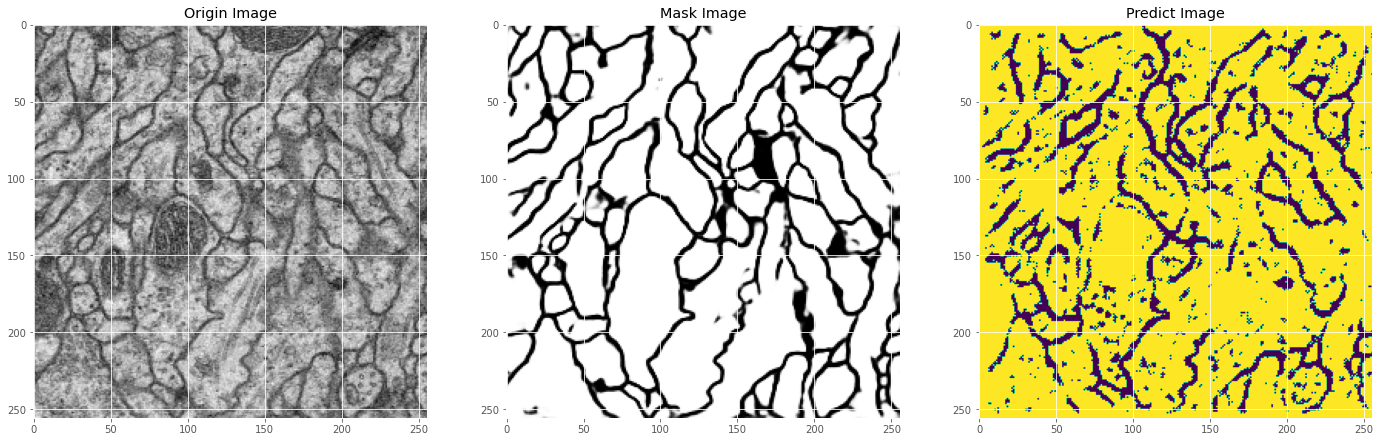

In [ ]:
import glob2

test_paths = glob2.glob('data/membrane/test/*.png')
test_paths = [path for path in test_paths if 'predict' not in path]

rand_ind = np.random.randint(5)
path = test_paths[rand_ind]
mask_path = path.replace('.png','_predict.png')
def predict_path(path, mask_path, figsize = (24, 8)):
  img = cv2.imread(path)
  img = cv2.resize(img, (INPUT_SHAPE, INPUT_SHAPE), cv2.INTER_LINEAR)
  img_expand = img[np.newaxis, ...]

  mask = cv2.imread(mask_path)
  mask = cv2.resize(mask, (INPUT_SHAPE, INPUT_SHAPE), cv2.INTER_LINEAR)

  img_pred = model.predict(img_expand).reshape(INPUT_SHAPE, INPUT_SHAPE)
  img_pred[img_pred < 0.5] = 0
  img_pred[img_pred >= 0.5] = 1
  plt.subplots(figsize = figsize)
  plt.subplot(1,3,3)
  plt.title('Predict Image')
  plt.imshow(img_pred)

  plt.subplot(1,3,2)
  plt.title('Mask Image')
  plt.imshow(mask)

  plt.subplot(1,3,1)
  plt.title('Origin Image')
  plt.imshow(img)

predict_path(path, mask_path)